In [1]:
import sys
sys.path.append('./paralel_planarity_criterion')

import os
import random
import networkx as nx
from glob import glob

from planarity_criterion import PlanarityCriterion  
import planar_printer

In [2]:
def load_random_graphs_from_folder(
    folder_path,
    node_range=None,
    cycle_metric_range=None,
    num_graphs=None,
    seed=42,
    verbose=1
):
    """
    Load a random subset (or all) of undirected graphs from .graphml files in a folder,
    filtered by node count (extracted from filename) and cycle space metric.

    Parameters:
        folder_path (str): Directory containing .graphml files.
        node_range (list or None): [min_nodes, max_nodes] constraint, or None to ignore.
        cycle_metric_range (list or None): [min, max] for (cycle_space_dim * num_edges), or None to ignore.
        num_graphs (int or None): Number of graphs to load. If None, load all matching graphs.
        seed (int): Random seed for reproducibility.
        verbose (int): 0 = silent, 1 = summary only, 2 = print stats for each selected graph.

    Returns:
        List of (filename, graph) tuples.
    """
    import os
    import re
    import random
    import networkx as nx
    from glob import glob

    random.seed(seed)
    all_files = glob(os.path.join(folder_path, "*.graphml"))
    if verbose >= 1:
        print(f"Found {len(all_files)} .graphml files in folder.")

    eligible_graphs = []

    for file in all_files:
        try:
            # Extract node count from filename
            base = os.path.basename(file)
            match = re.findall(r"\.(\d+)\.graphml$", base)
            if not match:
                continue
            file_node_count = int(match[0])
            
            # Node constraint check
            if node_range:
                min_nodes, max_nodes = node_range
                if not (min_nodes <= file_node_count <= max_nodes):
                    continue

            # Load graph
            G = nx.read_graphml(file)
            G = nx.Graph(G)
            n = G.number_of_nodes()
            m = G.number_of_edges()
            cycle_space_dim = m - n + 1
            cycle_metric = cycle_space_dim * m

            # Cycle metric constraint check
            if cycle_metric_range:
                min_cyc, max_cyc = cycle_metric_range
                if not (min_cyc <= cycle_metric <= max_cyc):
                    continue

            eligible_graphs.append((file, G))

        except Exception as e:
            if verbose >= 1:
                print(f"⚠️ Error reading {file}: {e}")

    if verbose >= 1:
        print(f"{len(eligible_graphs)} files matched the constraints.")

    if num_graphs is not None:
        selected_graphs = random.sample(eligible_graphs, min(num_graphs, len(eligible_graphs)))
        if verbose >= 1:
            print(f"Selected {len(selected_graphs)} graphs at random.\n")
    else:
        selected_graphs = eligible_graphs
        if verbose >= 1:
            print(f"Selected ALL {len(selected_graphs)} eligible graphs.\n")

    if verbose == 2:
        for file, G in selected_graphs:
            n = G.number_of_nodes()
            m = G.number_of_edges()
            cycle_space_dim = m - n + 1
            cycle_metric = cycle_space_dim * m
            print(f"{os.path.basename(file)} → nodes: {n}, edges: {m}, cycle_space_dim: {cycle_space_dim}, cycle_metric: {cycle_metric}")

    return selected_graphs


In [3]:
import time
import numpy as np


import time
import numpy as np

def test_planarity_on_graphs(graphs, verbose=2, algorithm="Planar-1"):
    """
    Test planarity on a list of (filename, graph) tuples using one of two algorithms.

    Parameters:
        graphs: List of (filename, networkx.Graph) tuples.
        verbose (int): 
            0 = silent unless mismatch,
            1 = summary only,
            2 = detailed output with timing, cycles, CNF vars.
        algorithm (str): 'Planar-1' (default, solver.is_planar) or 'Planar-2' (get_embedding method).

    Returns:
        timings: List of tuples (filename, your_time, networkx_time, ratio)
    """
    import os
    import networkx as nx
    from planarity_criterion import PlanarityCriterion
    import planar_printer

    solver = PlanarityCriterion()
    failed_graphs = []
    timings = []

    for file, G in graphs:
        try:
            n = G.number_of_nodes()
            m = G.number_of_edges()
            cycle_space_dim = m - n + 1
            cnf_vars = m * cycle_space_dim

            # Time your algorithm
            start_my = time.time()
            if algorithm == "Planar-1":
                my_result, info = solver.is_planar(G)
            elif algorithm == "Planar-2":
                try:
                    planar, _ = planar_printer.get_embbeding(G)
                    my_result = planar # all(embedding_result) if isinstance(embedding_result, list) else embedding_result
                    info = {"source": "Planar-2"}
                except Exception as e:
                    my_result = False
                    info = {"error": str(e)}
            else:
                raise ValueError(f"Unknown algorithm: {algorithm}")
            end_my = time.time()

            # Time NetworkX
            start_nx = time.time()
            nx_result, _ = nx.check_planarity(G)
            end_nx = time.time()

            my_time = end_my - start_my
            nx_time = end_nx - start_nx
            ratio = my_time / (nx_time + 1e-9)
            timings.append((os.path.basename(file), my_time, nx_time, ratio))

            if verbose == 2:
                print(f"Testing {os.path.basename(file)}")
                print(f" - Nodes: {n}, Edges: {m}")
                print(f" - Cycle space dimension: {cycle_space_dim}")
                print(f" - CNF variables (edges × cycle_space_dim): {cnf_vars}")
                print(f" - ⏱️ {algorithm} time: {my_time:.6f}s, NetworkX: {nx_time:.6f}s, Ratio: {ratio:.2f}x")

            if my_result != nx_result:
                failed_graphs.append(file)
                if verbose >= 1:
                    print("❌ Mismatch!")
                    print("File:", file)
                    if verbose == 2:
                        print("Nodes:", G.nodes())
                        print("Edges:", G.edges())
                        print("Info:", info)
                print()
            elif verbose == 2:
                print("✅ Match\n")

        except Exception as e:
            if verbose >= 1:
                print(f"⚠️ Error processing {file}: {e}")
            failed_graphs.append(file)

    # Summary
    if verbose >= 1 or failed_graphs:
        print(f"\n✅ Done. {len(failed_graphs)} mismatches found.")
        if failed_graphs:
            print("❌ Mismatched files:")
            for f in failed_graphs:
                print(" -", f)
        else:
            print("🎉 All tests passed.")

    if verbose >= 1:
        my_times = np.array([t[1] for t in timings])
        nx_times = np.array([t[2] for t in timings])
        ratios = np.array([t[3] for t in timings])

        print("\nTiming Summary:")
        print(f"Mean time — {algorithm}: {np.mean(my_times):.6f}s")
        print(f"Mean time — NetworkX   : {np.mean(nx_times):.6f}s")
        print(f"Mean time ratio ({algorithm} / networkx): {np.mean(ratios):.2f}x")

        if verbose == 2:
            print("\nPer-graph Timing & Ratios:")
            for fname, my_t, nx_t, r in timings:
                print(f"{fname}: {algorithm} = {my_t:.6f}s, NetworkX = {nx_t:.6f}s, Ratio = {r:.2f}x")

    return timings

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(graphs, cols=4, node_size=100):
    """
    Display all graphs in the list using matplotlib.

    Parameters:
        graphs: List of (filename, networkx.Graph) tuples.
        cols: Number of columns in the subplot grid.
        node_size: Size of graph nodes.
    """
    total = len(graphs)
    rows = (total + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten() if total > 1 else [axes]

    for i, (filename, G) in enumerate(graphs):
        ax = axes[i]
        ax.set_title(os.path.basename(filename), fontsize=8)
        nx.draw(G, ax=ax, with_labels=False, node_size=node_size)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


Found 11534 .graphml files in folder.
860 files matched the constraints.
Selected 20 graphs at random.



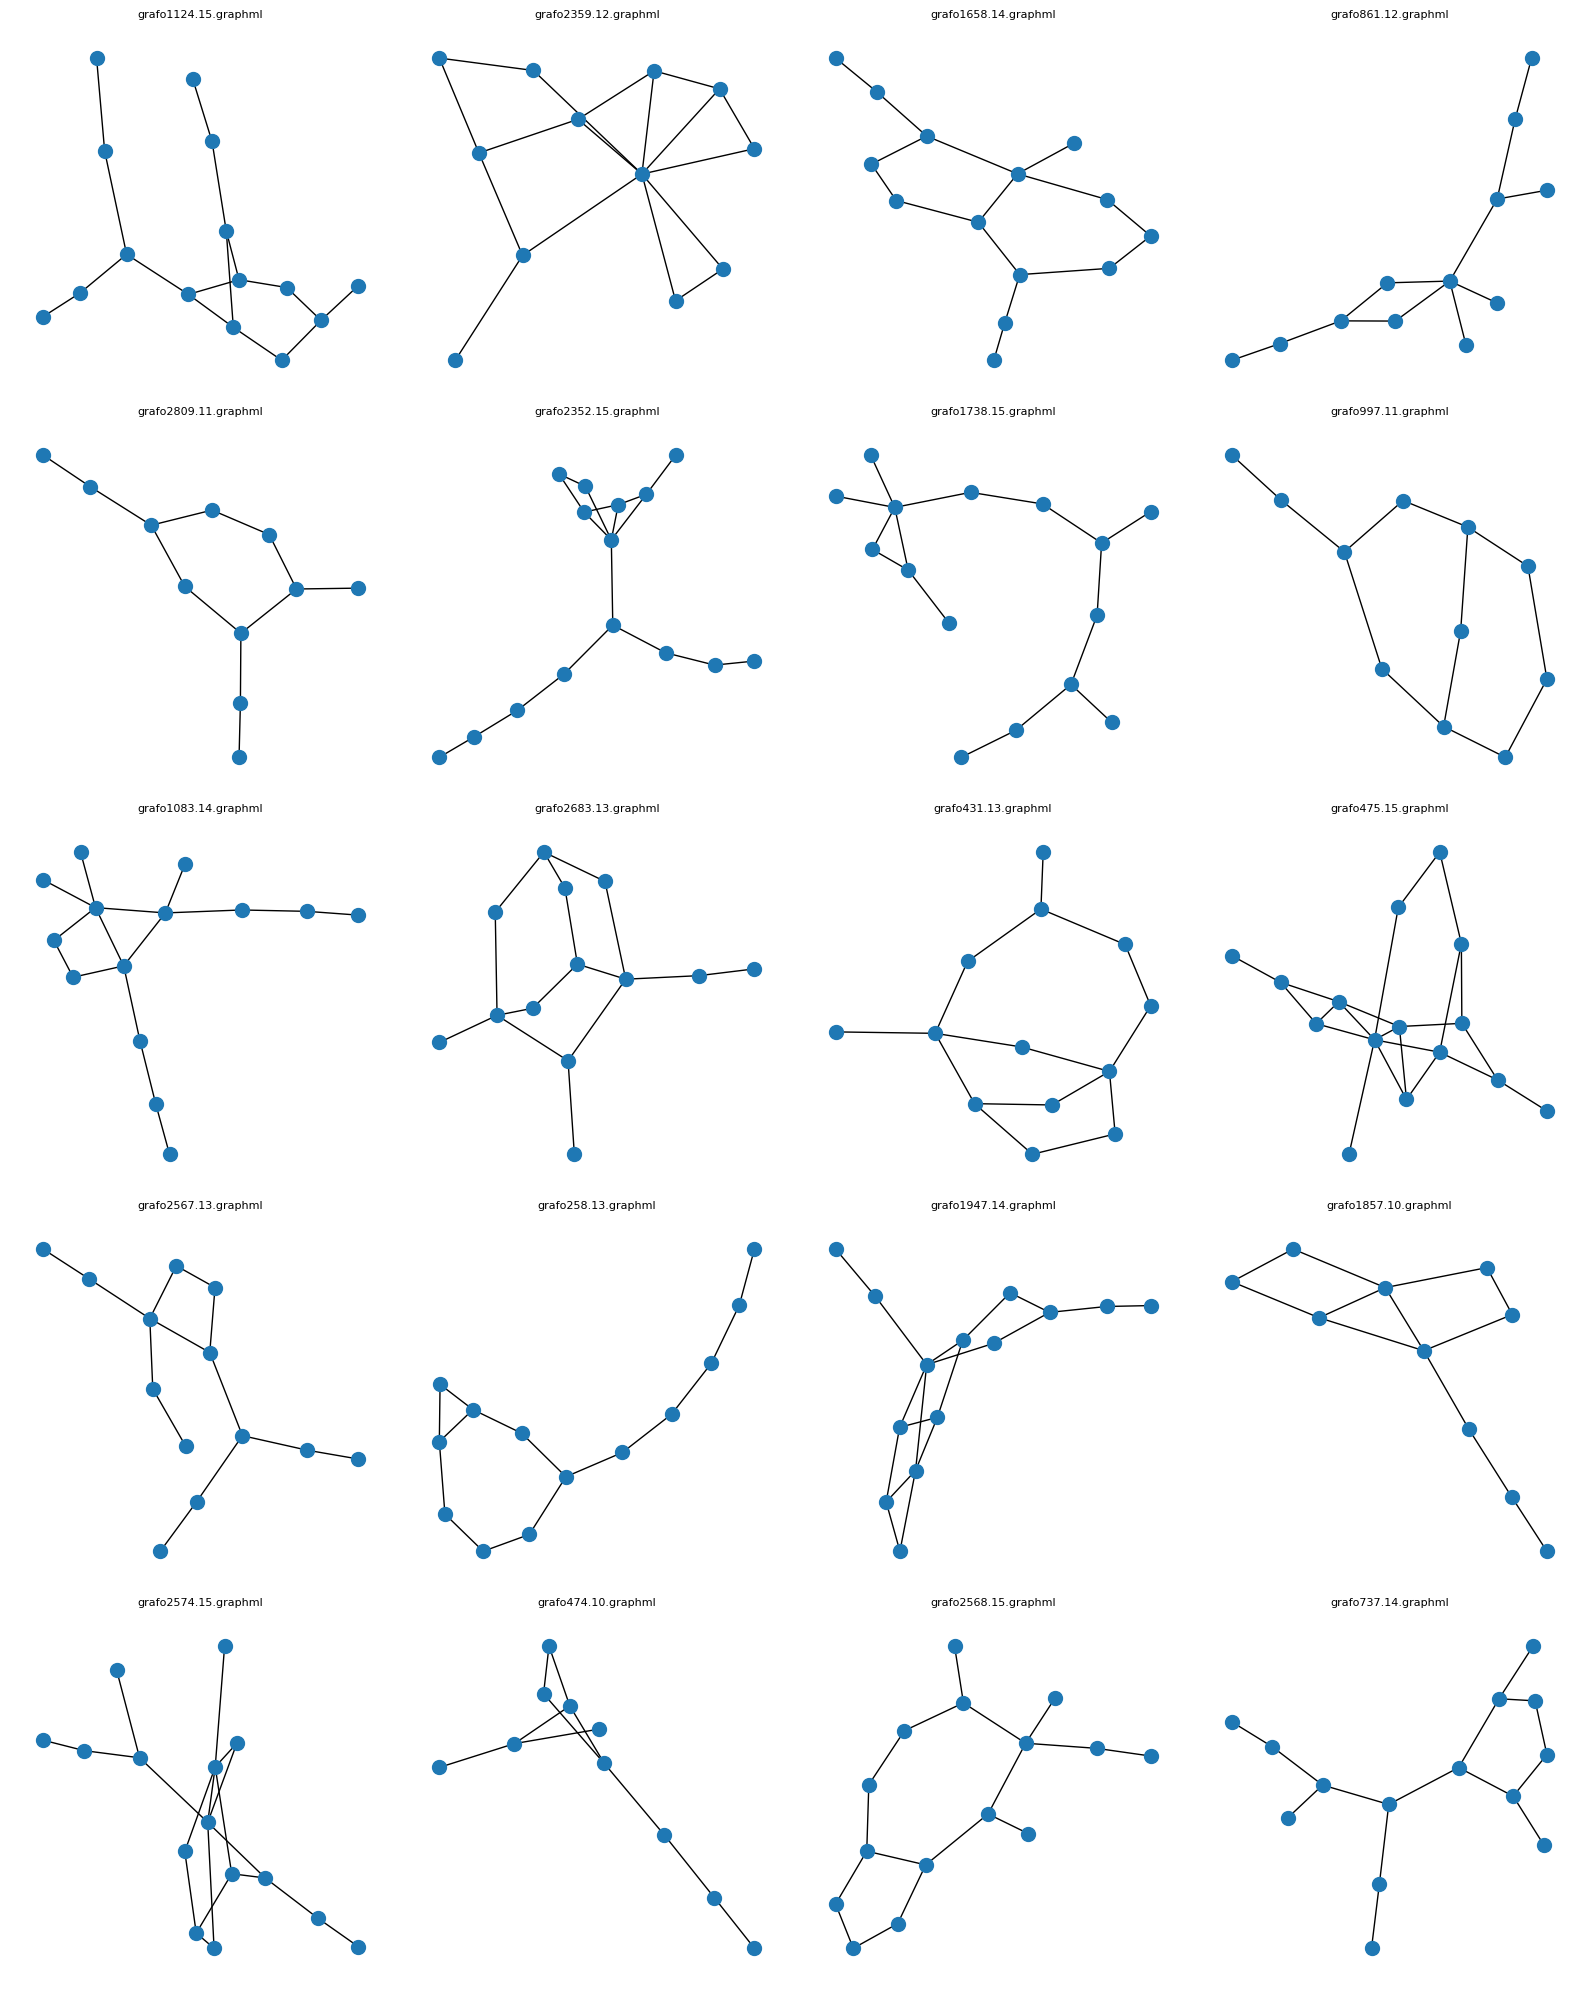

Testing grafo1124.15.graphml
 - Nodes: 15, Edges: 16
 - Cycle space dimension: 2
 - CNF variables (edges × cycle_space_dim): 32
 - ⏱️ Planar-1 time: 0.005342s, NetworkX: 0.001994s, Ratio: 2.68x
✅ Match

Testing grafo2359.12.graphml
 - Nodes: 12, Edges: 17
 - Cycle space dimension: 6
 - CNF variables (edges × cycle_space_dim): 102
 - ⏱️ Planar-1 time: 0.008137s, NetworkX: 0.000000s, Ratio: 8137226.10x
✅ Match

Testing grafo1658.14.graphml
 - Nodes: 14, Edges: 15
 - Cycle space dimension: 2
 - CNF variables (edges × cycle_space_dim): 30
 - ⏱️ Planar-1 time: 0.003016s, NetworkX: 0.000994s, Ratio: 3.03x
✅ Match

Testing grafo861.12.graphml
 - Nodes: 12, Edges: 12
 - Cycle space dimension: 1
 - CNF variables (edges × cycle_space_dim): 12
 - ⏱️ Planar-1 time: 0.000000s, NetworkX: 0.001023s, Ratio: 0.00x
✅ Match

Testing grafo2809.11.graphml
 - Nodes: 11, Edges: 11
 - Cycle space dimension: 1
 - CNF variables (edges × cycle_space_dim): 11
 - ⏱️ Planar-1 time: 0.000996s, NetworkX: 0.001003s, R

'\nMejores marcas:\n\nTesting grafo4453.57.graphml\n - Nodes: 57, Edges: 72\n - Cycle space dimension: 16\n - CNF variables (edges × cycle_space_dim): 1152\n - ⏱️ Planar-1 time: 588.986076s, NetworkX: 0.001049s, Ratio: 561706.30x\n ✅ Match\n\n Testing grafo3181.55.graphml\n - Nodes: 55, Edges: 77\n - Cycle space dimension: 23\n - CNF variables (edges × cycle_space_dim): 1771\n - ⏱️ Planar-1 time: 33745.582342s, NetworkX: 0.001993s, Ratio: 16930521.53x\n✅ Match\n\n \n'

In [5]:
graphs = load_random_graphs_from_folder("rome", node_range=[5, 15], cycle_metric_range=None, num_graphs=20, seed=123)  ### CON NODOS HASTA 15 TARDA UN BUEN RATO EN HACER TODOS
plot_graphs(graphs)
timings = test_planarity_on_graphs(graphs, algorithm="Planar-1")


"""
Mejores marcas:

Testing grafo4453.57.graphml
 - Nodes: 57, Edges: 72
 - Cycle space dimension: 16
 - CNF variables (edges × cycle_space_dim): 1152
 - ⏱️ Planar-1 time: 588.986076s, NetworkX: 0.001049s, Ratio: 561706.30x
 ✅ Match

 Testing grafo3181.55.graphml
 - Nodes: 55, Edges: 77
 - Cycle space dimension: 23
 - CNF variables (edges × cycle_space_dim): 1771
 - ⏱️ Planar-1 time: 33745.582342s, NetworkX: 0.001993s, Ratio: 16930521.53x
✅ Match

 
"""